### Testing Different Feature Types  
  
For each of these feature sets, the EEG preprocessing will involve standardization, highpass filtering, and re-referencing with the global average of the 19 scalp electrodes.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fastparquet, pyarrow
import mne
from scipy.stats import kurtosis, skew
from mne.decoding import Scaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score
from utils import *

In [2]:
mne.set_log_level('WARNING')

In [3]:
df = pd.read_csv('by_patient.csv')

In [4]:
other_df = activity_df(df, 'Other', 'expert_consensus')
seizure_df = activity_df(df, 'Seizure', 'expert_consensus')
gpd_df = activity_df(df, 'GPD', 'expert_consensus')
lpd_df = activity_df(df, 'LPD', 'expert_consensus')
grda_df = activity_df(df, 'GRDA', 'expert_consensus')
lrda_df = activity_df(df, 'LRDA', 'expert_consensus')
activity_df_list = [other_df, seizure_df, gpd_df, lpd_df, grda_df, lrda_df]

### Frequency Band Power  
  
EEG time series data is transformed into the frequency domain using Welch's method. The power of the signal within specified frequency bands is determined and used as feature data. There are five frequency bands: delta (0.5 - 4), theta (4 - 8), alpha (8 - 13), beta (13 - 30), gamma (30 - 100). Five band powers per EEG channel means 95 columns in the feature set.

In [5]:
y = get_yvals(2000)['activity']

In [9]:
X = pd.read_csv('glb_avg_df.csv')

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [10]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('Band Power Training')
print(classification_report(y_train, training_yhat))
print('Band Power Testing')
print(classification_report(y_test, testing_yhat))
band_power_acc = accuracy_score(y_test, testing_yhat)
band_power_macro_f1 = f1_score(y_test, testing_yhat, average = 'macro')
band_power_f1 = f1_score(y_test, testing_yhat, average = None)

Band Power Training
              precision    recall  f1-score   support

         GPD       0.83      0.93      0.88      1794
        GRDA       0.78      0.89      0.83      1819
         LPD       0.79      0.88      0.83      1800
        LRDA       0.85      0.89      0.87      1795
       Other       0.78      0.63      0.70      1808
     Seizure       0.90      0.69      0.78      1784

    accuracy                           0.82     10800
   macro avg       0.82      0.82      0.81     10800
weighted avg       0.82      0.82      0.81     10800

Band Power Testing
              precision    recall  f1-score   support

         GPD       0.73      0.87      0.80       206
        GRDA       0.66      0.81      0.72       181
         LPD       0.70      0.78      0.74       200
        LRDA       0.80      0.79      0.80       205
       Other       0.51      0.45      0.48       192
     Seizure       0.81      0.53      0.64       216

    accuracy                          

In [11]:
bandpow_train = accuracy_score(y_train, training_yhat).round(decimals = 3)
bandpow_test = accuracy_score(y_test, testing_yhat).round(decimals = 3)

### Frequency Band Energy  
  
Only difference is this is calculating energy for each EEG channel after transformation into the frequency domain instead of power as was done above.  
  
**ERROR:**  
  
Running the code to get the band energy feature data returned an error saying that the lowpass filter needed to be less than the nyquist frequency (sampling frequency / 2; determines the maximum frequency for the frequency domain of the data) which is 100 Hz for this data. I adjusted the lowpass filter, but it didn't resolve the issue, so I think there's a parameter setting for the compute_energy_freq_bands function that needs to be adjusted, but I don't know exactly how to do that. Moving on to other feature types. First are the fractal dimension features: Katz and Higuchi.  
  
### Katz Fractal Dimension

In [16]:
#katz_features = full_katz_df(2000, activity_df_list, 1, None, bandpass = True, notch = False, reref = True)
#katz_features.to_csv('katz_df.csv', index = None)

In [13]:
X = pd.read_csv('katz_df.csv')

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [16]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('Katz Fractal Dimension Training')
print(classification_report(y_train, training_yhat))
print('Katz Fractal Dimension Testing')
print(classification_report(y_test, testing_yhat))
katz_train = accuracy_score(y_train, training_yhat).round(decimals = 3)
katz_test = accuracy_score(y_test, testing_yhat).round(decimals = 3)
katz_macro_f1 = f1_score(y_test, testing_yhat, average = 'macro')
katz_f1 = f1_score(y_test, testing_yhat, average = None)

Katz Fractal Dimension Training
              precision    recall  f1-score   support

         GPD       0.79      0.89      0.84      1794
        GRDA       0.74      0.83      0.78      1819
         LPD       0.72      0.82      0.77      1800
        LRDA       0.80      0.85      0.82      1795
       Other       0.75      0.53      0.62      1808
     Seizure       0.76      0.66      0.71      1784

    accuracy                           0.76     10800
   macro avg       0.76      0.76      0.76     10800
weighted avg       0.76      0.76      0.76     10800

Katz Fractal Dimension Testing
              precision    recall  f1-score   support

         GPD       0.72      0.84      0.78       206
        GRDA       0.57      0.66      0.61       181
         LPD       0.62      0.70      0.66       200
        LRDA       0.67      0.75      0.71       205
       Other       0.52      0.33      0.40       192
     Seizure       0.66      0.52      0.58       216

    accuracy  

In [17]:
katz_train, katz_test

(0.761, 0.635)

In [10]:
f1_scores = pd.DataFrame(band_power_f1, index = ['GPD', 'GRDA', 'LPD', 'LRDA', 'Other', 'Seizure'], columns = ['Band Power'])

In [11]:
f1_scores['Katz'] = katz_f1

### Higuchi Fractal Dimension

In [12]:
#higuchi_df = full_higuchi_df(2000, activity_df_list, 1, None, bandpass = True, notch = False, reref = True)
#higuchi_df.to_csv('higuchi_df.csv', index = None)

In [18]:
X = pd.read_csv('higuchi_df.csv')

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [19]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('Higuchi Fractal Dimension Training')
print(classification_report(y_train, training_yhat))
print('Higuchi Fractal Dimension Testing')
print(classification_report(y_test, testing_yhat))
higuchi_train = accuracy_score(y_train, training_yhat).round(decimals = 3)
higuchi_test = accuracy_score(y_test, testing_yhat).round(decimals = 3)
higuchi_macro_f1 = f1_score(y_test, testing_yhat, average = 'macro')
higuchi_f1 = f1_score(y_test, testing_yhat, average = None)

Higuchi Fractal Dimension Training
              precision    recall  f1-score   support

         GPD       0.84      0.90      0.87      1794
        GRDA       0.80      0.83      0.82      1819
         LPD       0.74      0.87      0.80      1800
        LRDA       0.85      0.89      0.87      1795
       Other       0.76      0.58      0.66      1808
     Seizure       0.79      0.72      0.75      1784

    accuracy                           0.80     10800
   macro avg       0.80      0.80      0.79     10800
weighted avg       0.80      0.80      0.79     10800

Higuchi Fractal Dimension Testing
              precision    recall  f1-score   support

         GPD       0.84      0.77      0.80       206
        GRDA       0.68      0.71      0.69       181
         LPD       0.62      0.72      0.67       200
        LRDA       0.76      0.82      0.79       205
       Other       0.58      0.46      0.51       192
     Seizure       0.58      0.57      0.58       216

    accu

In [20]:
higuchi_train, higuchi_test

(0.798, 0.677)

In [14]:
f1_scores['Higuchi'] = higuchi_f1

In [15]:
f1_scores.round(decimals = 3)

,Band Power,Katz,Higuchi
GPD,0.796,0.777,0.803
GRDA,0.725,0.611,0.694
LPD,0.738,0.659,0.665
LRDA,0.796,0.705,0.789
Other,0.482,0.401,0.513
Seizure,0.640,0.580,0.577


### Zero Crossings  
  
This is a measure of how often the signal crosses zero. In other words, how often the signal moves from + to - and from - to +.

In [17]:
#zero_xing_df = full_zero_xing_df(2000, activity_df_list, 1, None, bandpass = True, notch = False, reref = True)
#zero_xing_df.to_csv('zero_xing_df.csv', index = None)

In [21]:
X = pd.read_csv('zero_xing_df.csv')

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [22]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('Zero Crossings Training')
print(classification_report(y_train, training_yhat))
print('Zero Crossings Testing')
print(classification_report(y_test, testing_yhat))
zero_xing_train = accuracy_score(y_train, training_yhat).round(decimals = 3)
zero_xing_test = accuracy_score(y_test, testing_yhat).round(decimals = 3)
zero_xing_macro_f1 = f1_score(y_test, testing_yhat, average = 'macro')
zero_xing_f1 = f1_score(y_test, testing_yhat, average = None)

Zero Crossings Training
              precision    recall  f1-score   support

         GPD       0.82      0.90      0.86      1794
        GRDA       0.82      0.83      0.83      1819
         LPD       0.77      0.84      0.80      1800
        LRDA       0.85      0.88      0.86      1795
       Other       0.77      0.60      0.68      1808
     Seizure       0.77      0.75      0.76      1784

    accuracy                           0.80     10800
   macro avg       0.80      0.80      0.80     10800
weighted avg       0.80      0.80      0.80     10800

Zero Crossings Testing
              precision    recall  f1-score   support

         GPD       0.72      0.80      0.76       206
        GRDA       0.68      0.65      0.66       181
         LPD       0.61      0.73      0.67       200
        LRDA       0.77      0.79      0.78       205
       Other       0.53      0.46      0.49       192
     Seizure       0.65      0.54      0.59       216

    accuracy                  

In [23]:
zero_xing_train, zero_xing_test

(0.801, 0.663)

In [24]:
f1_scores['Zero Crossings'] = zero_xing_f1

In [25]:
f1_scores.round(decimals = 3)

,Band Power,Katz,Higuchi,Zero Crossings
GPD,0.796,0.777,0.803,0.755
GRDA,0.725,0.611,0.694,0.694
LPD,0.738,0.659,0.665,0.654
LRDA,0.796,0.705,0.789,0.805
Other,0.482,0.401,0.513,0.469
Seizure,0.640,0.580,0.577,0.580


### Hjorth Complexity: Time-Domain

In [37]:
#comp_df = full_complexity_df(2000, activity_df_list, 1, None, bandpass = True, notch = False, reref = True, spectral = False)
#comp_df.to_csv('comp_df.csv', index = None)

In [24]:
X = pd.read_csv('comp_df.csv')

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [25]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('Hjorth Complexity Time Training')
print(classification_report(y_train, training_yhat))
print('Hjorth Complexity Time Testing')
print(classification_report(y_test, testing_yhat))
comp_train = accuracy_score(y_train, training_yhat).round(decimals = 3)
comp_test = accuracy_score(y_test, testing_yhat).round(decimals = 3)
comp_macro_f1 = f1_score(y_test, testing_yhat, average = 'macro')
comp_f1 = f1_score(y_test, testing_yhat, average = None)

Hjorth Complexity Time Training
              precision    recall  f1-score   support

         GPD       0.76      0.91      0.83      1794
        GRDA       0.83      0.83      0.83      1819
         LPD       0.74      0.85      0.79      1800
        LRDA       0.84      0.87      0.85      1795
       Other       0.77      0.57      0.65      1808
     Seizure       0.77      0.70      0.73      1784

    accuracy                           0.79     10800
   macro avg       0.79      0.79      0.78     10800
weighted avg       0.79      0.79      0.78     10800

Hjorth Complexity Time Testing
              precision    recall  f1-score   support

         GPD       0.68      0.86      0.76       206
        GRDA       0.70      0.75      0.72       181
         LPD       0.65      0.76      0.70       200
        LRDA       0.76      0.79      0.78       205
       Other       0.58      0.30      0.39       192
     Seizure       0.65      0.62      0.64       216

    accuracy  

In [26]:
comp_train, comp_test

(0.785, 0.68)

In [28]:
f1_scores['Time-Domain Complexity'] = comp_f1

### Hjorth Complexity: Frequency-Domain

In [25]:
#comp_df = full_complexity_df(2000, activity_df_list, 1, None, bandpass = True, notch = False, reref = True, spectral = True)
#comp_df.to_csv('comp_df.csv', index = None)

In [29]:
#comp_df.to_csv('spectral_comp_df.csv', index = None)

In [27]:
X = pd.read_csv('spectral_comp_df.csv')

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [28]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('Hjorth Complexity Frequency Training')
print(classification_report(y_train, training_yhat))
print('Hjorth Complexity Frequency Testing')
print(classification_report(y_test, testing_yhat))
spectral_comp_train = accuracy_score(y_train, training_yhat).round(decimals = 3)
spectral_comp_test = accuracy_score(y_test, testing_yhat).round(decimals = 3)
spectral_comp_macro_f1 = f1_score(y_test, testing_yhat, average = 'macro')
spectral_comp_f1 = f1_score(y_test, testing_yhat, average = None)

Hjorth Complexity Frequency Training
              precision    recall  f1-score   support

         GPD       0.72      0.89      0.80      1794
        GRDA       0.73      0.80      0.77      1819
         LPD       0.68      0.79      0.73      1800
        LRDA       0.75      0.82      0.79      1795
       Other       0.73      0.50      0.59      1808
     Seizure       0.77      0.57      0.65      1784

    accuracy                           0.73     10800
   macro avg       0.73      0.73      0.72     10800
weighted avg       0.73      0.73      0.72     10800

Hjorth Complexity Frequency Testing
              precision    recall  f1-score   support

         GPD       0.65      0.83      0.73       206
        GRDA       0.56      0.68      0.61       181
         LPD       0.52      0.70      0.60       200
        LRDA       0.67      0.72      0.69       205
       Other       0.53      0.26      0.34       192
     Seizure       0.68      0.42      0.52       216

    

In [29]:
spectral_comp_train, spectral_comp_test

(0.729, 0.602)

In [31]:
f1_scores['Spectral Complexity'] = spectral_comp_f1

### Hjorth Mobility: Time-Domain

In [41]:
#mob_df = full_mobility_df(2000, activity_df_list, 1, None, bandpass = True, notch = False, reref = True, spectral = False)
#mob_df.to_csv('mob_df.csv', index = None)

In [32]:
X = pd.read_csv('mob_df.csv')

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [33]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('Hjorth Mobility Time Training')
print(classification_report(y_train, training_yhat))
print('Hjorth Mobility Time Testing')
print(classification_report(y_test, testing_yhat))
mob_acc = accuracy_score(y_test, testing_yhat)
mob_macro_f1 = f1_score(y_test, testing_yhat, average = 'macro')
mob_f1 = f1_score(y_test, testing_yhat, average = None)

Hjorth Mobility Time Training
              precision    recall  f1-score   support

         GPD       0.78      0.90      0.83      1794
        GRDA       0.80      0.83      0.82      1819
         LPD       0.75      0.85      0.80      1800
        LRDA       0.85      0.88      0.86      1795
       Other       0.79      0.55      0.65      1808
     Seizure       0.76      0.71      0.74      1784

    accuracy                           0.79     10800
   macro avg       0.79      0.79      0.78     10800
weighted avg       0.79      0.79      0.78     10800

Hjorth Mobility Time Testing
              precision    recall  f1-score   support

         GPD       0.68      0.79      0.73       206
        GRDA       0.64      0.66      0.65       181
         LPD       0.61      0.68      0.64       200
        LRDA       0.70      0.79      0.74       205
       Other       0.51      0.34      0.41       192
     Seizure       0.61      0.54      0.57       216

    accuracy      

In [34]:
f1_scores['Time-Domain Mobility'] = mob_f1

### Hjorth Mobility: Frequency-Domain

In [46]:
#spectral_mob_df = full_mobility_df(2000, activity_df_list, 1, None, bandpass = True, notch = False, reref = True, spectral = True)
#spectral_mob_df.to_csv('spectral_mob_df.csv', index = None)

In [35]:
X = pd.read_csv('spectral_mob_df.csv')

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [36]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('Hjorth Mobility Frequency Training')
print(classification_report(y_train, training_yhat))
print('Hjorth Mobility Frequency Testing')
print(classification_report(y_test, testing_yhat))
spectral_mob_acc = accuracy_score(y_test, testing_yhat)
spectral_mob_macro_f1 = f1_score(y_test, testing_yhat, average = 'macro')
spectral_mob_f1 = f1_score(y_test, testing_yhat, average = None)

Hjorth Mobility Frequency Training
              precision    recall  f1-score   support

         GPD       0.74      0.88      0.81      1794
        GRDA       0.72      0.80      0.76      1819
         LPD       0.71      0.79      0.75      1800
        LRDA       0.77      0.84      0.80      1795
       Other       0.75      0.52      0.61      1808
     Seizure       0.78      0.61      0.68      1784

    accuracy                           0.74     10800
   macro avg       0.74      0.74      0.74     10800
weighted avg       0.74      0.74      0.74     10800

Hjorth Mobility Frequency Testing
              precision    recall  f1-score   support

         GPD       0.64      0.78      0.70       206
        GRDA       0.56      0.66      0.60       181
         LPD       0.58      0.64      0.60       200
        LRDA       0.67      0.75      0.71       205
       Other       0.50      0.32      0.39       192
     Seizure       0.58      0.44      0.50       216

    accu

In [37]:
f1_scores['Spectral Mobility'] = spectral_mob_f1

### Line Length

In [38]:
#linelength_df = full_linelength_df(2000, activity_df_list, 1, None, bandpass = True,
                                  notch = False, reref = True)
#linelength_df.to_csv('linelength_df.csv', index = None)

In [39]:
X = pd.read_csv('linelength_df.csv')

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [40]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('Line Length Training')
print(classification_report(y_train, training_yhat))
print('Line Length Testing')
print(classification_report(y_test, testing_yhat))
linelength_acc = accuracy_score(y_test, testing_yhat)
linelength_macro_f1 = f1_score(y_test, testing_yhat, average = 'macro')
linelength_f1 = f1_score(y_test, testing_yhat, average = None)

Line Length Training
              precision    recall  f1-score   support

         GPD       0.78      0.89      0.83      1794
        GRDA       0.78      0.83      0.80      1819
         LPD       0.72      0.83      0.77      1800
        LRDA       0.80      0.86      0.83      1795
       Other       0.79      0.54      0.64      1808
     Seizure       0.76      0.67      0.71      1784

    accuracy                           0.77     10800
   macro avg       0.77      0.77      0.77     10800
weighted avg       0.77      0.77      0.77     10800

Line Length Testing
              precision    recall  f1-score   support

         GPD       0.72      0.76      0.74       206
        GRDA       0.63      0.72      0.67       181
         LPD       0.58      0.74      0.65       200
        LRDA       0.72      0.76      0.74       205
       Other       0.56      0.38      0.45       192
     Seizure       0.67      0.55      0.60       216

    accuracy                        

In [41]:
f1_scores['Line Length'] = linelength_f1

### Decorrelation Time

In [42]:
#decorr_time_df = full_decorr_df(2000, activity_df_list, 1, None, bandpass = True,
                               notch = False, reref = True)
#decorr_time_df.to_csv('decorr_time_df.csv', index = None)

In [31]:
X = pd.read_csv('decorr_time_df.csv')

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

### Worst Results by Wide Margin  
  
Follows the trend of the other feature sets with the four generalized and lateralized activities showing the best results of the 6 and then a large drop off to other and seizure. Performance is worse across the board relative to the other feature sets and the big difference that distinguishes this feature set from the others is that other and seizure show essentially equivalent results by precision, recall, and f1. The feature sets before this showed better results with seizure than other.  
  
I won't be using this feature.

In [32]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('Decorrelation Time Training')
print(classification_report(y_train, training_yhat))
print('Decorrelation Time Testing')
print(classification_report(y_test, testing_yhat))
decorr_train = accuracy_score(y_train, training_yhat).round(decimals = 3)
decorr_test = accuracy_score(y_test, testing_yhat).round(decimals = 3)
decorr_macro_f1 = f1_score(y_test, testing_yhat, average = 'macro')
decorr_f1 = f1_score(y_test, testing_yhat, average = None)

Decorrelation Time Training
              precision    recall  f1-score   support

         GPD       0.70      0.89      0.79      1794
        GRDA       0.65      0.78      0.71      1819
         LPD       0.69      0.72      0.70      1800
        LRDA       0.74      0.80      0.77      1795
       Other       0.67      0.50      0.58      1808
     Seizure       0.74      0.48      0.58      1784

    accuracy                           0.70     10800
   macro avg       0.70      0.70      0.69     10800
weighted avg       0.70      0.70      0.69     10800

Decorrelation Time Testing
              precision    recall  f1-score   support

         GPD       0.57      0.76      0.65       206
        GRDA       0.51      0.67      0.58       181
         LPD       0.45      0.48      0.47       200
        LRDA       0.65      0.68      0.67       205
       Other       0.49      0.33      0.39       192
     Seizure       0.52      0.31      0.39       216

    accuracy          

In [33]:
decorr_train, decorr_test

(0.697, 0.538)

In [46]:
f1_scores['Decorr Time'] = decorr_f1

### Spectral Edge Frequency

In [47]:
#edge_freq_df = full_edge_freq_df(2000, activity_df_list, 1, None, bandpass = True,
                                notch = False, reref = True)
#edge_freq_df.to_csv('edge_freq_df.csv', index = None)

In [48]:
X = pd.read_csv('edge_freq_df.csv')

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [49]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('Spectral Edge Frequency Training')
print(classification_report(y_train, training_yhat))
print('Spectral Edge Frequency Testing')
print(classification_report(y_test, testing_yhat))
edge_freq_acc = accuracy_score(y_test, testing_yhat)
edge_freq_macro_f1 = f1_score(y_test, testing_yhat, average = 'macro')
edge_freq_f1 = f1_score(y_test, testing_yhat, average = None)

Spectral Edge Frequency Training
              precision    recall  f1-score   support

         GPD       0.71      0.88      0.78      1794
        GRDA       0.66      0.73      0.69      1819
         LPD       0.71      0.72      0.72      1800
        LRDA       0.68      0.79      0.73      1795
       Other       0.71      0.51      0.60      1808
     Seizure       0.78      0.58      0.66      1784

    accuracy                           0.70     10800
   macro avg       0.71      0.70      0.70     10800
weighted avg       0.71      0.70      0.70     10800

Spectral Edge Frequency Testing
              precision    recall  f1-score   support

         GPD       0.64      0.80      0.71       206
        GRDA       0.50      0.59      0.54       181
         LPD       0.61      0.65      0.63       200
        LRDA       0.59      0.69      0.64       205
       Other       0.53      0.31      0.39       192
     Seizure       0.66      0.50      0.57       216

    accuracy

In [50]:
f1_scores['Edge Frequency'] = edge_freq_f1

### Spectral Slope  
  
Returns slope, intercept, mse, and r2.

In [51]:
#spect_slope_df = full_spect_slope_df(2000, activity_df_list, 1, None, bandpass = True,
                                    notch = False, reref = True)
#spect_slope_df.to_csv('spect_slope_df.csv', index = None)

In [52]:
X = pd.read_csv('spect_slope_df.csv')

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [53]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('Spectral Slope Training')
print(classification_report(y_train, training_yhat))
print('Spectral Slope Testing')
print(classification_report(y_test, testing_yhat))
spect_slope_acc = accuracy_score(y_test, testing_yhat)
spect_slope_macro_f1 = f1_score(y_test, testing_yhat, average = 'macro')
spect_slope_f1 = f1_score(y_test, testing_yhat, average = None)

Spectral Slope Training
              precision    recall  f1-score   support

         GPD       0.85      0.92      0.89      1794
        GRDA       0.75      0.88      0.81      1819
         LPD       0.79      0.87      0.83      1800
        LRDA       0.81      0.89      0.85      1795
       Other       0.76      0.60      0.67      1808
     Seizure       0.86      0.64      0.74      1784

    accuracy                           0.80     10800
   macro avg       0.80      0.80      0.80     10800
weighted avg       0.80      0.80      0.80     10800

Spectral Slope Testing
              precision    recall  f1-score   support

         GPD       0.75      0.84      0.79       206
        GRDA       0.62      0.76      0.68       181
         LPD       0.64      0.79      0.70       200
        LRDA       0.74      0.78      0.76       205
       Other       0.61      0.47      0.53       192
     Seizure       0.79      0.49      0.60       216

    accuracy                  

In [54]:
f1_scores['Spectral Slope'] = spect_slope_f1

### Wavelet Coef Energy

In [58]:
#coef_energy_df = full_coef_energy_df('db4', 2000, activity_df_list, 1, None, bandpass = True,
                                    notch = False, reref = True)
#coef_energy_df.to_csv('coef_energy_df.csv', index = None)

In [34]:
X = pd.read_csv('coef_energy_df.csv')

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [35]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('Wavelet Coef Energy Training')
print(classification_report(y_train, training_yhat))
print('Wavelet Coef Energy Testing')
print(classification_report(y_test, testing_yhat))
coef_energy_train = accuracy_score(y_train, training_yhat).round(decimals = 3)
coef_energy_test = accuracy_score(y_test, testing_yhat).round(decimals = 3)
coef_energy_macro_f1 = f1_score(y_test, testing_yhat, average = 'macro')
coef_energy_f1 = f1_score(y_test, testing_yhat, average = None)

Wavelet Coef Energy Training
              precision    recall  f1-score   support

         GPD       0.82      0.93      0.87      1794
        GRDA       0.77      0.87      0.82      1819
         LPD       0.79      0.87      0.83      1800
        LRDA       0.80      0.89      0.84      1795
       Other       0.77      0.62      0.69      1808
     Seizure       0.87      0.61      0.72      1784

    accuracy                           0.80     10800
   macro avg       0.80      0.80      0.79     10800
weighted avg       0.80      0.80      0.79     10800

Wavelet Coef Energy Testing
              precision    recall  f1-score   support

         GPD       0.73      0.86      0.79       206
        GRDA       0.59      0.72      0.65       181
         LPD       0.64      0.76      0.70       200
        LRDA       0.72      0.80      0.75       205
       Other       0.51      0.38      0.44       192
     Seizure       0.77      0.46      0.58       216

    accuracy        

In [36]:
coef_energy_train, coef_energy_test

(0.799, 0.663)

In [61]:
f1_scores['Coef Energy'] = coef_energy_f1

### Teager Kaiser Energy

In [62]:
#tk_energy_df = full_tk_energy_df('db4', 2000, activity_df_list, 1, None, bandpass = True,
                                notch = False, reref = True)
#tk_energy_df.to_csv('tk_energy_df.csv', index = None)

In [37]:
X = pd.read_csv('tk_energy_df.csv')

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [38]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('Teager Kaiser Energy Training')
print(classification_report(y_train, training_yhat))
print('Teager Kaiser Energy Testing')
print(classification_report(y_test, testing_yhat))
tk_energy_train = accuracy_score(y_train, training_yhat).round(decimals = 3)
tk_energy_test = accuracy_score(y_test, testing_yhat).round(decimals = 3)
tk_energy_macro_f1 = f1_score(y_test, testing_yhat, average = 'macro')
tk_energy_f1 = f1_score(y_test, testing_yhat, average = None)

Teager Kaiser Energy Training
              precision    recall  f1-score   support

         GPD       0.82      0.93      0.88      1794
        GRDA       0.76      0.88      0.82      1819
         LPD       0.78      0.85      0.81      1800
        LRDA       0.80      0.90      0.85      1795
       Other       0.78      0.61      0.68      1808
     Seizure       0.88      0.63      0.74      1784

    accuracy                           0.80     10800
   macro avg       0.80      0.80      0.80     10800
weighted avg       0.80      0.80      0.80     10800

Teager Kaiser Energy Testing
              precision    recall  f1-score   support

         GPD       0.75      0.86      0.80       206
        GRDA       0.63      0.74      0.68       181
         LPD       0.68      0.75      0.71       200
        LRDA       0.68      0.76      0.72       205
       Other       0.56      0.47      0.51       192
     Seizure       0.74      0.49      0.59       216

    accuracy      

In [39]:
tk_energy_train, tk_energy_test

(0.801, 0.678)

In [67]:
f1_scores['Teager Kaiser'] = tk_energy_f1

In [68]:
f1_scores.round(decimals = 3)

,Band Power,Katz,Higuchi,Zero Crossings,Time-Domain Complexity,Spectral Complexity,Time-Domain Mobility,Spectral Mobility,Line Length,Decorr Time,Edge Frequency,Spectral Slope,Coef Energy,Teager Kaiser
GPD,0.796,0.777,0.803,0.755,0.761,0.726,0.731,0.700,0.739,0.654,0.711,0.790,0.834,0.821
GRDA,0.725,0.611,0.694,0.694,0.724,0.613,0.649,0.603,0.670,0.579,0.539,0.681,0.657,0.681
LPD,0.738,0.659,0.665,0.654,0.699,0.601,0.643,0.605,0.653,0.463,0.628,0.704,0.714,0.709
LRDA,0.796,0.705,0.789,0.805,0.775,0.692,0.743,0.708,0.738,0.668,0.638,0.762,0.733,0.789
Other,0.482,0.401,0.513,0.469,0.393,0.344,0.408,0.391,0.453,0.390,0.392,0.529,0.460,0.521
Seizure,0.640,0.580,0.577,0.580,0.635,0.521,0.572,0.496,0.602,0.387,0.566,0.604,0.561,0.602


### ECG Statistical Features

In [128]:
def load_scale_ecg(data, row):
    ecg = np.asarray(get_sub_eeg(data, row)['EKG'])
    ecg = pd.DataFrame(ecg, columns = ['EKG'])
    scaler = MinMaxScaler()
    ecg = scaler.fit_transform(ecg)
    return ecg.ravel()

def get_ecg_stats(ecg):
    ecg_stats = np.asarray([np.mean(ecg), np.var(ecg), kurtosis(ecg), skew(ecg)])
    return pd.DataFrame(ecg_stats, index = ['Mean', 'Variance', 'Kurtosis', 'Skewness']).transpose()

def ecg_stats_df(data, size):
    rows = [i for i in range(data.shape[0])]
    random_rows = np.random.choice(rows, size = size, replace = False)
    ecg_stats_set = pd.DataFrame()
    for i in random_rows:
        ecg = load_scale_ecg(data, i)
        ecg_stats = get_ecg_stats(ecg)
        ecg_stats_set = pd.concat([ecg_stats_set, ecg_stats], ignore_index = True)
    return ecg_stats_set

def full_ecg_stats_df(size, activity_df_list):
    ecg_stats_feature_set = pd.DataFrame()
    for df in activity_df_list:
        ecg_stats_set = ecg_stats_df(df, size)
        ecg_stats_feature_set = pd.concat([ecg_stats_feature_set, ecg_stats_set], ignore_index = True)
    return ecg_stats_feature_set

In [130]:
#ecg_stats_df = full_ecg_stats_df(2000, activity_df_list)
#ecg_stats_df.to_csv('ecg_stats_df.csv', index = None)

In [131]:
X = pd.read_csv('ecg_stats_df.csv')

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

### Worst Results  
  
Extracting statistical features from the ECG data was not effective. 44% testing accuracy is by far the worst result of any feature set. Maybe over smaller intervals there would be more useful information here, but it's likely that in order to get useful information from the ECG data, the approach would be to determine HVR. If there were more than a week and a half left this semester, I'd work on figuring out how to go about doing that, but for this project, I'll be moving forward without ECG features.

In [132]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('ECG Statistical Features Training')
print(classification_report(y_train, training_yhat))
print('ECG Statistical Features Testing')
print(classification_report(y_test, testing_yhat))
ecg_stats_acc = accuracy_score(y_test, testing_yhat)
ecg_stats_macro_f1 = f1_score(y_test, testing_yhat, average = 'macro')
ecg_stats_f1 = f1_score(y_test, testing_yhat, average = None)

ECG Statistical Features Training
              precision    recall  f1-score   support

         GPD       0.53      0.74      0.62      1794
        GRDA       0.56      0.66      0.61      1819
         LPD       0.61      0.59      0.60      1800
        LRDA       0.65      0.65      0.65      1795
       Other       0.57      0.39      0.46      1808
     Seizure       0.64      0.51      0.57      1784

    accuracy                           0.59     10800
   macro avg       0.59      0.59      0.58     10800
weighted avg       0.59      0.59      0.58     10800

ECG Statistical Features Testing
              precision    recall  f1-score   support

         GPD       0.47      0.61      0.53       206
        GRDA       0.36      0.44      0.40       181
         LPD       0.40      0.41      0.41       200
        LRDA       0.52      0.56      0.54       205
       Other       0.30      0.19      0.23       192
     Seizure       0.52      0.40      0.45       216

    accura

In [133]:
f1_scores['ECG Stats'] = ecg_stats_f1

### Hjorth Time Domain

In [81]:
X1 = pd.read_csv('time_comp_df.csv')
X2 = pd.read_csv('time_mob_df.csv')
cols1, cols2 = X1.columns, X2.columns

In [82]:
scaler = StandardScaler()
X1 = scaler.fit_transform(X1)
X1 = pd.DataFrame(X1, columns = cols1)

scaler = StandardScaler()
X2 = scaler.fit_transform(X2)
X2 = pd.DataFrame(X2, columns = cols2)

X = pd.concat([X1, X2], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [83]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('Hjorth Time Training')
print(classification_report(y_train, training_yhat))
print('Hjorth Time Testing')
print(classification_report(y_test, testing_yhat))
hjorth_time_train = accuracy_score(y_train, training_yhat).round(decimals = 3)
hjorth_time_test = accuracy_score(y_test, testing_yhat).round(decimals = 3)
hjorth_time_macro_f1 = f1_score(y_test, testing_yhat, average = 'macro')
hjorth_time_f1 = f1_score(y_test, testing_yhat, average = None)

Hjorth Time Training
              precision    recall  f1-score   support

         GPD       0.78      0.92      0.85      1794
        GRDA       0.83      0.83      0.83      1819
         LPD       0.76      0.88      0.81      1800
        LRDA       0.84      0.87      0.85      1795
       Other       0.78      0.58      0.67      1808
     Seizure       0.79      0.70      0.74      1784

    accuracy                           0.80     10800
   macro avg       0.80      0.80      0.79     10800
weighted avg       0.80      0.80      0.79     10800

Hjorth Time Testing
              precision    recall  f1-score   support

         GPD       0.73      0.83      0.78       206
        GRDA       0.65      0.71      0.68       181
         LPD       0.64      0.72      0.68       200
        LRDA       0.75      0.80      0.77       205
       Other       0.49      0.38      0.42       192
     Seizure       0.68      0.55      0.61       216

    accuracy                        

In [84]:
hjorth_time_train, hjorth_time_test

(0.795, 0.667)

### Hjorth Frequency Domain

In [85]:
X1 = pd.read_csv('freq_comp_df.csv')
X2 = pd.read_csv('spectral_mob_df.csv')
cols1, cols2 = X1.columns, X2.columns

scaler = StandardScaler()
X1 = scaler.fit_transform(X1)
X1 = pd.DataFrame(X1, columns = cols1)

scaler = StandardScaler()
X2 = scaler.fit_transform(X2)
X2 = pd.DataFrame(X2, columns = cols2)

X = pd.concat([X1, X2], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [86]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('Hjorth Frequency Training')
print(classification_report(y_train, training_yhat))
print('Hjorth Frequency Testing')
print(classification_report(y_test, testing_yhat))
hjorth_freq_train = accuracy_score(y_train, training_yhat).round(decimals = 3)
hjorth_freq_test = accuracy_score(y_test, testing_yhat).round(decimals = 3)
hjorth_freq_macro_f1 = f1_score(y_test, testing_yhat, average = 'macro')
hjorth_freq_f1 = f1_score(y_test, testing_yhat, average = None)

Hjorth Frequency Training
              precision    recall  f1-score   support

         GPD       0.74      0.89      0.81      1794
        GRDA       0.71      0.79      0.75      1819
         LPD       0.69      0.81      0.74      1800
        LRDA       0.77      0.83      0.80      1795
       Other       0.73      0.50      0.60      1808
     Seizure       0.79      0.58      0.67      1784

    accuracy                           0.73     10800
   macro avg       0.74      0.73      0.73     10800
weighted avg       0.74      0.73      0.73     10800

Hjorth Frequency Testing
              precision    recall  f1-score   support

         GPD       0.66      0.77      0.71       206
        GRDA       0.56      0.66      0.61       181
         LPD       0.54      0.63      0.58       200
        LRDA       0.66      0.75      0.70       205
       Other       0.46      0.31      0.37       192
     Seizure       0.64      0.45      0.53       216

    accuracy              

In [88]:
hjorth_freq_train, hjorth_freq_test

(0.734, 0.595)

### Hjorth Altogether

In [89]:
X1 = pd.read_csv('time_comp_df.csv')
X2 = pd.read_csv('time_mob_df.csv')
X3 = pd.read_csv('freq_comp_df.csv')
X4 = pd.read_csv('spectral_mob_df.csv')
cols1, cols2 = X1.columns, X2.columns
cols3, cols4 = X3.columns, X4.columns

scaler = StandardScaler()
X1 = scaler.fit_transform(X1)
X1 = pd.DataFrame(X1, columns = cols1)

scaler = StandardScaler()
X2 = scaler.fit_transform(X2)
X2 = pd.DataFrame(X2, columns = cols2)

scaler = StandardScaler()
X3 = scaler.fit_transform(X3)
X3 = pd.DataFrame(X3, columns = cols3)

scaler = StandardScaler()
X4 = scaler.fit_transform(X4)
X4 = pd.DataFrame(X4, columns = cols4)

X = pd.concat([X1, X2], axis = 1)
X = pd.concat([X, X3], axis = 1)
X = pd.concat([X, X4], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [90]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('Hjorth Altogether Training')
print(classification_report(y_train, training_yhat))
print('Hjorth Altogether Testing')
print(classification_report(y_test, testing_yhat))
hjorth_train = accuracy_score(y_train, training_yhat).round(decimals = 3)
hjorth_test = accuracy_score(y_test, testing_yhat).round(decimals = 3)
hjorth_macro_f1 = f1_score(y_test, testing_yhat, average = 'macro')
hjorth_f1 = f1_score(y_test, testing_yhat, average = None)

Hjorth Altogether Training
              precision    recall  f1-score   support

         GPD       0.77      0.92      0.84      1794
        GRDA       0.82      0.83      0.83      1819
         LPD       0.77      0.87      0.82      1800
        LRDA       0.83      0.87      0.85      1795
       Other       0.80      0.59      0.68      1808
     Seizure       0.80      0.72      0.75      1784

    accuracy                           0.80     10800
   macro avg       0.80      0.80      0.79     10800
weighted avg       0.80      0.80      0.79     10800

Hjorth Altogether Testing
              precision    recall  f1-score   support

         GPD       0.71      0.85      0.77       206
        GRDA       0.63      0.72      0.67       181
         LPD       0.64      0.71      0.67       200
        LRDA       0.74      0.77      0.76       205
       Other       0.57      0.38      0.46       192
     Seizure       0.70      0.59      0.64       216

    accuracy            

In [91]:
hjorth_train, hjorth_test

(0.797, 0.672)

### Visualization of Results  
  
Below I'm going to make some bar plots to compare the different feature sets tested above. I've realized that because of the way I wrote my functions, everytime I make a feature set, a new random set of indexes is chosen. These feature sets aren't extracted from the same sub EEGs and that means I can't concatenate them and test them together. I'll have to re-do that in a separate notebook. Once I've done that testing, I'll begin working on dimensionality reduction, feature selection, and clustering.

In [94]:
train_scores = [bandpow_train, higuchi_train, zero_xing_train, tk_energy_train, hjorth_train]
test_scores = [bandpow_test, higuchi_test, zero_xing_test, tk_energy_test, hjorth_test]
feature_types = ['Band Power', 'Higuchi FD', 'Zero Crossings', 'TK Energy', 'Mobility & Complexity']
feature_sets = ['Set {}'.format(i) for i in range(1, 6)]

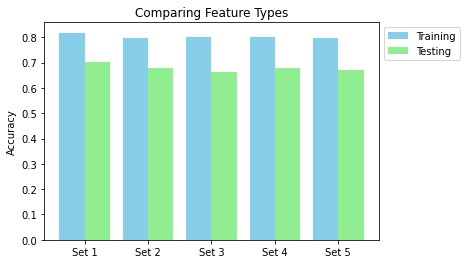

In [100]:
X_axis = np.arange(len(feature_sets))

plt.bar(X_axis - 0.2, train_scores, 0.4, label = 'Training', color = 'skyblue') 
plt.bar(X_axis + 0.2, test_scores, 0.4, label = 'Testing', color = 'lightgreen') 
  
plt.xticks(X_axis, feature_sets)
plt.ylabel('Accuracy') 
plt.title('Comparing Feature Types')
plt.legend(bbox_to_anchor = [1, 1], loc = 'upper left')
plt.show()

In [98]:
feature_table = pd.DataFrame([feature_types, train_scores, test_scores],
                             index = ['Feature Type', 'Training', 'Testing'],
                             columns = feature_sets).transpose()

In [99]:
feature_table

,Feature Type,Training,Testing
Set 1,Band Power,0.818,0.703
Set 2,Higuchi FD,0.798,0.677
Set 3,Zero Crossings,0.801,0.663
Set 4,TK Energy,0.801,0.678
Set 5,Mobility & Complexity,0.797,0.672
